<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/E4P2S9_Multi_Class_Question_Type_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Nov 24 12:53:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Source : https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/5%20-%20Multi-class%20Sentiment%20Analysis.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)                      # We are using seed to ensure that we get similar data while splitting train & test data
torch.backends.cudnn.deterministic = True
txt = data.Field(tokenize = 'spacy')
lbl = data.LabelField()

#### We are using TREC dataset here. This is a dataset of questions and task is to classify what category question belongs to. train_data is organized in such a way that a single element contains a field, 'text', along with all the tokens representing the text, and a 'label' field that contains the label of the text (eg: in this case 'HUM' 'ENTY','DESC','NUM','LOC','ABBR'). 'fine_grained' argument allows us to use the fine-grained labels (of which there are 50 classes) or not (in which case they'll be 6 classes). We are using fine_grained = False to use 6 classes only.
#### HUM for questions about humans
#### ENTY for questions about entities
#### DESC for questions asking you for a description
#### NUM for questions where the answer is numerical
#### LOC for questions where the answer is a location
#### ABBR for questions asking about abbreviations

In [ ]:
from torchtext import datasets
import random
train_data, test_data = datasets.TREC.splits(txt, lbl, fine_grained=False)

downloading train_5500.label


train_5500.label: 100%|██████████| 336k/336k [00:00<00:00, 1.07MB/s]


downloading TREC_10.label


TREC_10.label: 100%|██████████| 23.4k/23.4k [00:00<00:00, 302kB/s]


In [ ]:
print('Length of train_data:',len(train_data), 'Type:', type(train_data))
print('Length of test_data :',len(test_data), 'Type:', type(test_data))
print(train_data.fields)
print(test_data.fields)
print(vars(train_data.examples[0]))   # vars -> Built-in function, with an argument equivalent to object.dict. 
print(vars(test_data.examples[0])) 
print(vars(train_data[-1]))

Length of train_data: 5452 Type: torchtext.datasets.trec.TREC
Length of test_data : 500 Type: torchtext.datasets.trec.TREC
{'text': <torchtext.data.field.Field object at 0x7f1ffd411da0>, 'label': <torchtext.data.field.LabelField object at 0x7f1ffd411dd8>}
{'text': <torchtext.data.field.Field object at 0x7f1ffd411da0>, 'label': <torchtext.data.field.LabelField object at 0x7f1ffd411dd8>}
{'text': ['How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], 'label': 'DESC'}
{'text': ['How', 'far', 'is', 'it', 'from', 'Denver', 'to', 'Aspen', '?'], 'label': 'NUM'}
{'text': ['What', 'currency', 'is', 'used', 'in', 'Australia', '?'], 'label': 'ENTY'}


##### Split the train_data further into train_data & valid_data

In [ ]:
import random
train_data, valid_data = train_data.split(split_ratio=0.85,random_state=random.seed(SEED))

In [ ]:
print('Length of train_data:',len(train_data))
print('Length of valid_data:',len(valid_data))
print('Length of test_data:',len(test_data))

Length of train_data: 3708
Length of valid_data: 654
Length of test_data: 500


### Building vocabulary. Here we WON'T restrict to top 25,000 words as dataset is small (~ 3708 train examples) which has ~7500 unique words. Also we are going to use pre-trained vector glove.6B.100d. This means glove was trained on 6 Billion words & have 100 dimensions. unk_init is meant for initialization of out-of-vocabulary word vectors (<unk>). Please note that building vocabulary means building a dictionary of words from input document.

In [ ]:
txt.build_vocab(train_data, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
lbl.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:31, 2.20MB/s]                           
100%|█████████▉| 398716/400000 [00:24<00:00, 15601.34it/s]

In [ ]:
print('Unique words in txt:',len(txt.vocab))   # Extra 2 elements because of unk & pad. Pad is used to make batch_size same for shorter sentences
print('Unique words in lbl:',len(lbl.vocab))

Unique words in txt: 7327
Unique words in lbl: 6


In [ ]:
print(txt.vocab.freqs.most_common(25))  # Printing most commonly occuring 25 words

[('?', 3642), ('the', 2452), ('What', 2207), ('is', 1149), ('of', 1066), ('in', 766), ('a', 686), ('`', 554), ('How', 503), ("'s", 491), ('was', 428), ('to', 425), (',', 392), ('Who', 383), ('for', 310), ('are', 290), ('and', 285), ('does', 275), ("''", 267), ('did', 251), ('-', 232), ('do', 227), ('many', 220), ('on', 219), ('Where', 201)]


## How to see vocabulary directly ? 
We can  see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.

In [ ]:
print(txt.vocab.itos[:10])     # First 10
print(txt.vocab.itos[77:90])   # In between
print(txt.vocab.itos[-10:])    # Last 10. 

['<unk>', '<pad>', '?', 'the', 'What', 'is', 'of', 'in', 'a', '`']
['about', 'known', 'two', 'its', 'origin', 'your', 'stand', 'New', 'TV', 'company', 'word', 'War', 'best']
['z', 'zebras', 'zeros', 'zipper', 'zitoni', 'zodiac', 'zodiacal', 'zone', 'zoo', 'zoonose']


In [ ]:
print(txt.vocab.stoi)
print(lbl.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f1faf58f158>, {'<unk>': 0, '<pad>': 1, '?': 2, 'the': 3, 'What': 4, 'is': 5, 'of': 6, 'in': 7, 'a': 8, '`': 9, 'How': 10, "'s": 11, 'was': 12, 'to': 13, ',': 14, 'Who': 15, 'for': 16, 'are': 17, 'and': 18, 'does': 19, "''": 20, 'did': 21, '-': 22, 'do': 23, 'many': 24, 'on': 25, 'Where': 26, 'name': 27, 'I': 28, 'can': 29, 'first': 30, 'you': 31, 'from': 32, 'The': 33, 'U.S.': 34, 'most': 35, 'that': 36, 'by': 37, 'have': 38, 'country': 39, 'When': 40, 'what': 41, 'as': 42, 'with': 43, 'an': 44, 'world': 45, 'Why': 46, 'has': 47, '.': 48, 'city': 49, "'": 50, 'Which': 51, 'there': 52, 'people': 53, 'find': 54, 'it': 55, 'Name': 56, 'get': 57, 'were': 58, 'at': 59, 'be': 60, 'American': 61, 'year': 62, 'his': 63, 'mean': 64, 'called': 65, 'much': 66, 'fear': 67, 'largest': 68, 'made': 69, 'state': 70, 'between': 71, 'used': 72, 'when': 73, ':': 74, 'long': 75, 'In': 76, 'about': 77, 'known': 78, 'two': 79, 'its': 80, 'origin': 81, 'your': 8

#### Creating iterator. Using buckeiterator that will return batch of examples where each example is of similar length, minimizing the amount of padding per example. 

In [ ]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                                            batch_size = batch_size,
                                                                            device = device)

#### Here we will use convolutions. Using filters, we will look at the n-grams of sentence. For example filter size nxd where n is the n-gram we need to read and d is the embedding dimension. Let us say we wish to read 3 words in a go i.e tri-gram and embedding dimension is 5, then filter we will be using is 3x5. Convolution followed by maxpooling will be fed to linear layer for sentiment prediction. Below diagramatic representation will give an idea how convolutions are used to extract features from embeddings.

#### Intuition behind using convolution layers for text: Presence of specific bi-grams or tri-grams will be indicative of the overall sentiment user is trying to present in review (movies in this example)

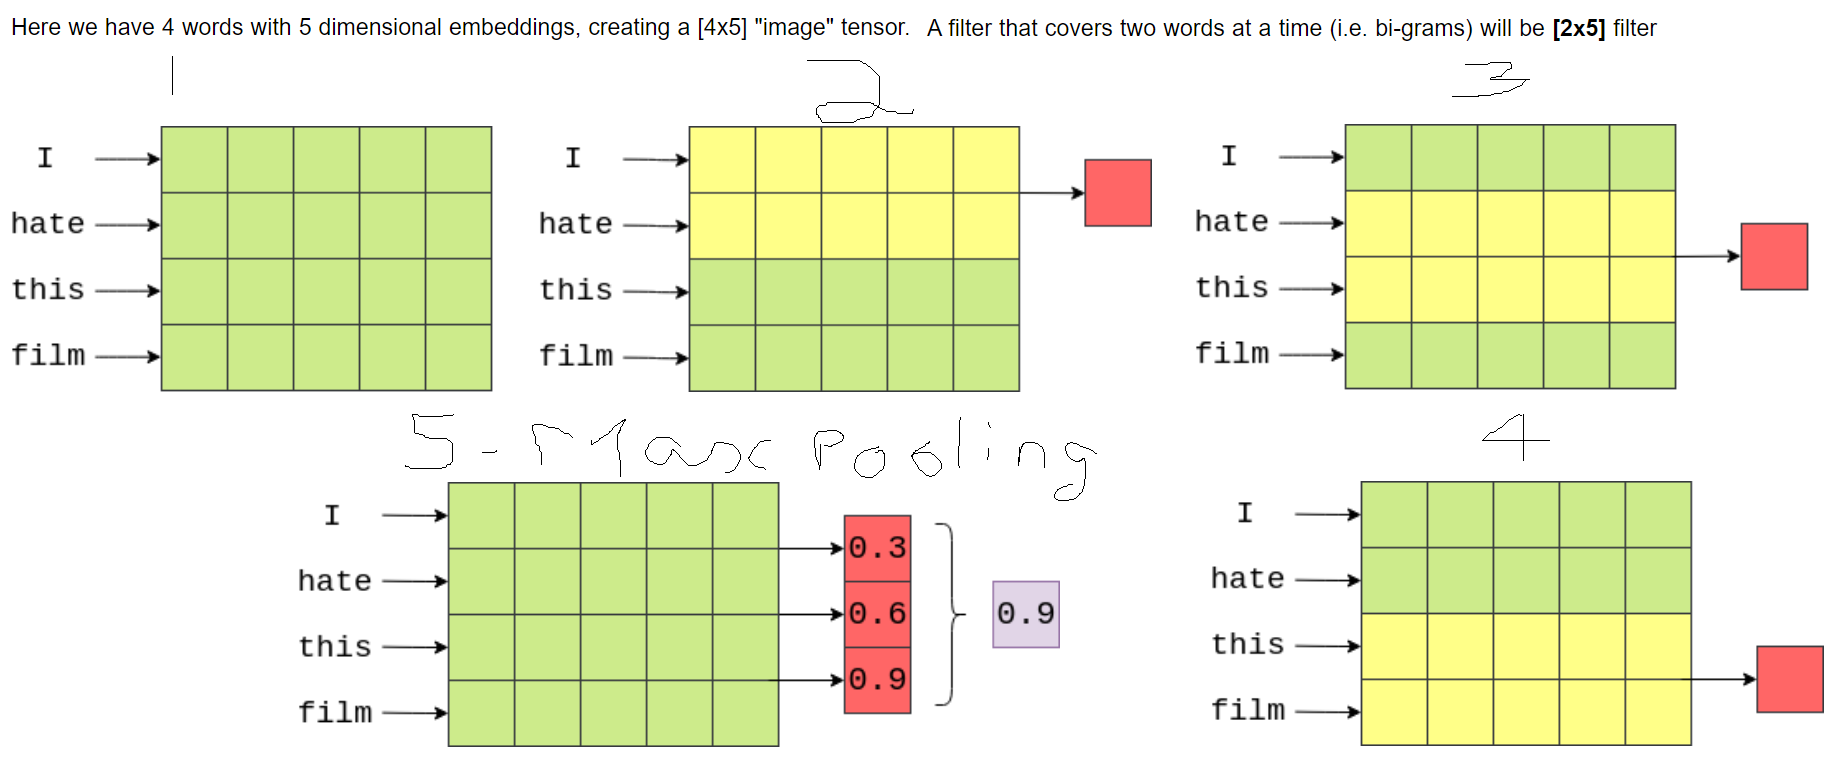

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
     def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
         super().__init__()
         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)  
         # We are passing idx of padded tokens so that we can avoid learning embeddings for <pad> token. 
         # <pad> tokens are irrelevant for our task here - ie predicting sentiment from movie reviews. 
         self.convs     = nn.ModuleList([nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (fs, embedding_dim))
                                         for fs in filter_sizes])
         # nn.ModuleList --> a function used to hold a list of PyTorch nn.Modules
         # This help us to create convolution layers based on size of filter_sizes which is a python list eg : [2, 3, 4]
         self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)  # --> len(filter_sizes) = 3, n_filters = 100, so 3*100 input -> 1 output

         self.dropout = nn.Dropout(dropout)
     
     def forward(self, text):  
         #text = [sentence len, batch size] --> eg: [1150, 64] means 64 sentences with 1150 words each. Length of sentence will vary for each batch.   
         text = text.permute(1,0)
         #text = [batch size, sentence len] --> eg: [64, 1150] means 64 sentences with 1150 words each. Length of sentence will vary for each batch.
         #we didn't give 'batch_first = True' while data pre-processing, hence has to pemute here as CNN wants batch_dimension first
         embedded = self.embedding(text)
         #embedded = [batch size, sentence len, emb dim] --> [64, 1150, 100] adding one more dimension for embed dimension

         embedded = embedded.unsqueeze(1)  
         #embedded = [batch size, 1, sentence len, emb dim] --> [64, 1, 1150, 100]

         conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  
         # Output will be like based on filter_size torch.Size([64, 100, 1148]), torch.Size([64, 100, 1147]), torch.Size([64, 100, 1146]), .......
         # conv_n = [batch size, n_filters, sentence len - filter_sizes[n] + 1]
                  
         pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  
         # Kernel size of max pool -> sentence len - filter_sizes[n] + 1 --> 1148, 1147 etc.
         # Output size of max pool is [batch size, n_filters, 1] --> [64, 100, 1]
         # squeeze(2) will make it [batch size, n_filters]  --> [64, 100]
         # pooled = [batch size, n_filters]. We will get as many pooled output as no: of elements in filter_sizes

         cat = self.dropout(torch.cat((pooled), dim=1)) # cat = [batch size, n_filters * len(filter_sizes)] --> torch.Size([64, 300])
         return self.fc(cat)  

In [ ]:
input_dim = len(txt.vocab)   # 7327
embedding_dim = 100          # EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier (glove.6B.100d) 
n_filters     = 100
filter_sizes  = [2,3,4]      # We are using tri-grams, 4-grams and 5-grams 
output_dim    = len(lbl.vocab)     # we will have 6 values 
dropout       = 0.5
pad_idx       = txt.vocab.stoi[txt.pad_token]   #we are finding index of pad token i.e. we are finiding index of <pad> in vocabulary we built

model = CNN(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 824,806 trainable parameters


#### Copying the pre-trained word embeddings (txt.vocab that we built using 'build_vocab') we loaded earlier into the embedding layer of our model

In [ ]:
pretrained_embeddings = txt.vocab.vectors
print(pretrained_embeddings.shape)
print(txt.vocab.vectors.shape)

torch.Size([7327, 100])
torch.Size([7327, 100])


#### Replace the initial weights of the embedding layer with the pre-trained embeddings.

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.1638,  0.6046,  1.0789,  ..., -0.3140,  0.1844,  0.3624],
        ...,
        [-0.3110, -0.3398,  1.0308,  ...,  0.5317,  0.2836, -0.0640],
        [ 0.0091,  0.2810,  0.7356,  ..., -0.7508,  0.8967, -0.7631],
        [-1.2660,  0.2298, -0.0242,  ..., -1.5512, -0.9168,  0.1620]])

##### Manually setting rows corresponding to 'unk' and 'pad' in the embedding weights matrix to zeros.

In [ ]:
unk_idx = txt.vocab.stoi[txt.unk_token]
print('unk_idx, txt.unk_token :', unk_idx, txt.unk_token)
model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)
print(model.embedding.weight.data.shape)

unk_idx, txt.unk_token : 0 <unk>
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1638,  0.6046,  1.0789,  ..., -0.3140,  0.1844,  0.3624],
        ...,
        [-0.3110, -0.3398,  1.0308,  ...,  0.5317,  0.2836, -0.0640],
        [ 0.0091,  0.2810,  0.7356,  ..., -0.7508,  0.8967, -0.7631],
        [-1.2660,  0.2298, -0.0242,  ..., -1.5512, -0.9168,  0.1620]])
torch.Size([7327, 100])


##### SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. Hence using Adam in this example

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #Get index with maximum probability using argmax
    max_preds = preds.argmax(dim=1, keepdim = True)
    correct = max_preds.squeeze(1).eq(y) # Comparing prediction with actual label
    #acc = correct.sum() / torch.FloatTensor([y.shape[0]])
    acc = correct.sum() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for idx, batch in enumerate(iterator):       
        optimizer.zero_grad()      
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc  = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()    

    return epoch_loss / len(iterator), epoch_acc / len(iterator)   

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        for idx, batch in enumerate(iterator):      
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc  = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc  += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)       

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
n_epochs = 20
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Multiclass_Question_Type_Analysis.pt')
       
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.019 | Train Acc: 99.76%
	 Val. Loss: 0.522 |  Val. Acc: 84.62%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.015 | Train Acc: 99.81%
	 Val. Loss: 0.522 |  Val. Acc: 84.76%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.013 | Train Acc: 99.84%
	 Val. Loss: 0.528 |  Val. Acc: 84.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.014 | Train Acc: 99.76%
	 Val. Loss: 0.543 |  Val. Acc: 85.41%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.012 | Train Acc: 99.84%
	 Val. Loss: 0.542 |  Val. Acc: 83.40%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.84%
	 Val. Loss: 0.540 |  Val. Acc: 84.48%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.89%
	 Val. Loss: 0.546 |  Val. Acc: 83.83%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.010 | Train Acc: 99.89%
	 Val. Loss: 0.553 |  Val. Acc: 83.83%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.89%
	 Val. Loss: 0.561 |  Val. Acc: 84.25%
Epoch: 10 | Epoch Time: 0m 0

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Multiclass_Question_Type_Analysis.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.350 | Test Acc: 89.29%


##### Giving user input to get the sentiment back. Please note that we trained on movie review comments, hence input also should be similar text.

In [ ]:
import spacy
nlp = spacy.load('en')  #'en' is language_id that indicates english

# The input sentence has to be at least as long as the largest filter height used (in our case 4 because we gave [2, 3, 4]). Else CNN will break due
# to Max-pooling filter size vs sentence length issue. Max pool filter wont be able to cover even one pooling if sent length < max pool filter height.
# Hence, we modify our predict_sentiment function to also accept a minimum length argument. 
# If the tokenized input sentence is less than min_len tokens, we append padding tokens (<pad>) to make it min_len tokens.

def predict_sentiment(model, sentence, min_len = 4):  # We are giving min_len = 4 bcoz. ie largest Maxpool filter we used
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]   # tokenizing the sentence
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))  # Padding tokens to match it with min_len 
    indexed = [txt.vocab.stoi[t] for t in tokenized]  # indexes the tokens by converting them into their integer representation from our vocabulary
    # "pathetic movie" --> indexed representation will be [1316, 22, 1, 1, 1] , 1316 ->pathetic , 22-> movie, 1 -> <pad> 
    tensor    = torch.LongTensor(indexed).to(device)  # converts 'indexed' which is a Python list into a PyTorch tensor
    tensor    = tensor.unsqueeze(1)                   # adding batch dimension to feed it to GPU
    preds     = model(tensor) 
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [ ]:
predict_sentiment(model, "Who is Keyser Söze?")

0

In [ ]:
predict_sentiment(model, "How many minutes are in six hundred and eighteen hours?") 

3

In [ ]:
predict_sentiment(model, "What continent is Bulgaria in?")

4

In [ ]:
predict_sentiment(model, "What does WYSIWYG stand for?")

5